## RLlib for multi-agent RL

In [1]:
# HIDDEN
import gym
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 16
# https://github.com/sven1977/rllib_tutorials/blob/main/ray_summit_2021/tutorial_notebook.ipynb
# https://github.com/anyscale/ray-summit-2022-training/blob/main/ray-rllib/ex_02_create_multiagent_rllib_env.ipynb

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

#### Multi-agent RL

- So far we've dealt with one agent
- Multi-agent RL deals with multiple agents
- This could be competitive, e.g. two parties engaging in monetary transactions
- It could be cooperative, e.g. two robots trying to complete a task together
- See [this fun video](https://www.youtube.com/watch?v=Lu56xVlZ40M) for a competitive hide and seek game!

Notes:

Relationship to game theory, especially in the competitive scenarios.

#### Multi agent arena

![](img/multi-agent-arena.png)

Notes:

This arena game will be our running example.

We have two agents, agent 1 and agent 2. In this case they have the same actions spaces and observations spaces but (critically) different reward functions. Agent 1 gets positive rewards if it explores a new square field, and a negative reward if it collides with agent 2. Agent 2 gets positive reward if it collides with agent 2. So in a way this is a game of tag, with agent 2 trying to catch agent 1, but agent 1 also has the additional goal of trying to explore territory rather than purely just running away. Since the field is 8x8, there are 64 squares. Our observation space is MultiDiscrete(64,64) because it contains the location of agent 1 (discrete 64) and agent 2 (also discrete 64).

#### Testing out the multi-agent env

We import the env (code available on the course GitHub):

In [2]:
from envs import MultiAgentArena

In [3]:
env = MultiAgentArena()
env.reset()

{'agent1': array([ 0, 99]), 'agent2': array([99,  0])}

What is the observation space?

In [4]:
env.observation_space

MultiDiscrete([100 100])

- We see that it's `MultiDiscrete([100 100])`.
- Actually it is `MultiDiscrete([100 100])` _for each agent_.
- The 100 comes from the 10x10 grid, and represents one location.
- Agent 1 observes the locations of Agents 1 and 2.
- Agent 2 observes the locations of Agents 1 and 2.
- In this particular env, both agents observe the same thing, though each agent sees itself "first".

#### Testing out the multi-agent env

Let's look at the action space now:

In [5]:
env.action_space

Discrete(4)

- Again, this is for each agent.
- The env uses the same convention as Frozen Lake: 0=left, 1=down, 2=right, 3=up

In [6]:
obs, rewards, dones, _ = env.step({"agent1": 1, "agent2": 3}) # agent 1: down, agent2: up

In [7]:
env.render()

____________
|.         |
|1         |
|          |
|          |
|          |
|          |
|          |
|          |
|         2|
|          |
‾‾‾‾‾‾‾‾‾‾‾‾

R1= 1.0
R2=-0.1 (0 collisions)



#### Testing out the multi-agent env

In [8]:
obs

{'agent1': array([10, 89]), 'agent2': array([89, 10])}

This makes sense given the observation space mapping:

```
--------------------------------
| 0  1  2  3  4  5  6  7  8  9 |
|10 11 12 13 14 15 16 17 18 19 |
|20 21 22 23 24 25 26 27 28 29 |
|30 31 32 33 34 35 36 37 38 39 |
|40 41 42 43 44 45 46 47 48 49 |
|50 51 52 53 54 55 56 57 58 59 |
|60 61 62 63 64 65 66 67 68 69 |
|70 71 72 73 74 75 76 77 78 79 |
|80 81 82 83 84 85 86 87 88 89 |
|90 91 92 93 94 95 96 97 98 99 |
--------------------------------
```

In [9]:
# HIDDEN

# for i in range(32):
#     print("-", end="")
# print()
# for i in range(10):
#     print("|", end="")
#     for j in range(10):
#         print(f"{j + i*10:2d}", end=" ")
#     print("|")
# for i in range(32):
#     print("-", end="")

#### Testing out the multi-agent env

Let's also look at the rewards and dones returned by `step()`:

In [10]:
rewards

{'agent1': 1.0, 'agent2': -0.1}

Here we see how agent 1 collected reward of +1 for exploring whereas agent 2 collected -0.1 for a regular move.

In [11]:
dones

{'agent1': False, 'agent2': False, '__all__': False}

The `"__all__"` is True when both (all) agents are done.

Note how agent 1 collected reward of +1 for exploring whereas agent 2 collected -0.1 for a regular move.

#### Multi-agent training with RLlib

We can see that PPO support multi-agent from the Ray docs [here](https://docs.ray.io/en/latest/rllib/rllib-algorithms.html#available-algorithms-overview).

In [12]:
# HIDDEN
from ray.rllib.algorithms.ppo import PPOConfig

In [13]:
# This is the same as before
ppo_config = (
    PPOConfig()\
    .framework("torch")\
    .rollouts(create_env_on_local_worker=True)\
    .debugging(seed=0, log_level="ERROR")\
    .training(model={"fcnet_hiddens" : [64, 64]})\
)

# This is new
ppo_config = ppo_config.multi_agent(
    policies=["policy1", "policy2"],
    policy_mapping_fn=lambda agent_id, episode, worker, **kwargs: "policy1" if agent_id == "agent1" else "policy2"
)

In [14]:
# TODO
# use a default config for the above, to make it cleaner

- We name the policies and map the agent ids to policy ids.
- The policy ids must match in the two lines above.
- The agent ids must match the env:

In [15]:
obs

{'agent1': array([10, 89]), 'agent2': array([89, 10])}

#### Multi-policy

![](img/from_single_agent_to_multi_agent.png)

In the previous code, we defined _separate policies_ for the two agents.

#### Training

Let's build the algorithm and train for 20 iterations:

In [16]:
ppo = ppo_config.build(env=MultiAgentArena)

In [17]:
rewards1 = []
rewards2 = []
for i in range(20):
    result = ppo.train()
    rewards1.append(result['policy_reward_mean']['policy1'])
    rewards2.append(result['policy_reward_mean']['policy2'])

(RolloutWorker pid=62038) /Users/mike/git/anyscale/ray/python/ray/rllib/utils/debug/deterministic.py:42: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
(RolloutWorker pid=62038)   if LooseVersion(torch.__version__) >= LooseVersion("1.8.0"):
(RolloutWorker pid=62038) /Users/mike/miniconda3/envs/ray2beta/lib/python3.9/site-packages/gym/core.py:268: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
(RolloutWorker pid=62038)   deprecation(
(RolloutWorker pid=62037) /Users/mike/git/anyscale/ray/python/ray/rllib/utils/debug/deterministic.py:42: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
(RolloutWorker pid=62037)   if LooseVersion(torch.__version__) >= LooseVersion("1.8.0"):
(RolloutWorker pid=62037) /Users/mike/miniconda3/envs/ray2beta/lib/python3.9/site-packages/gym/core.py:268: DeprecationWarn

In [18]:
# HIDDEN
rewards1 = np.array(rewards1)
rewards2 = np.array(rewards2)

#### Training curve

It looks like learning is happening!

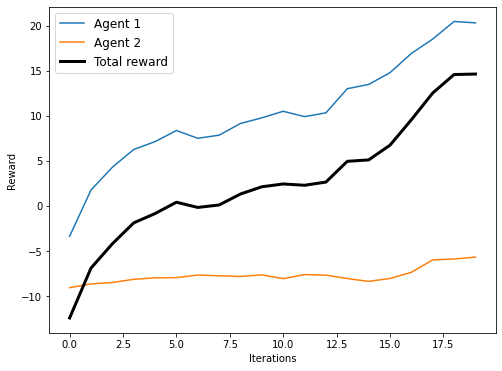

In [19]:
plt.figure(figsize=(8,6));
plt.plot(rewards1, label="Agent 1")
plt.plot(rewards2, label="Agent 2")
plt.plot(rewards1+rewards2, label="Total reward", linewidth=3, color="black")
plt.legend(fontsize=12);
plt.xlabel("Iterations")
plt.ylabel("Reward");

Notes:

Note that in an adversarial multi-agent setup, an agent benefits from the other agent's failures and vice-versa: agents receive negative rewards the better the other agent is doing. This highlights some important aspects of multi-agent training:

- From each agent's perspective, the environment is not as static as in respective single-agent scenarios (the other agent's behavior is probably harder to predict than the environment's own inherent dynamics/physics).
- As one agent learns how to behave more intelligently, the other agent has to counter this new behavior of its opponent and become smarter as well. 

#### Actions

When we want to use the trained agents, we still use `compute_single_action` but twice:

In [20]:
obs = env.reset()

In [21]:
ppo.compute_single_action(obs["agent1"], policy_id="policy1")

0

Agent 1 moves  

In [39]:
ppo.compute_single_action(obs["agent2"], policy_id="policy2")

2

Agent 2 moves 

We need to pass in the observation for that agent, and also the correct policy since we are using separate policies.

## TODO

why are they moving in weird directions?

also, we should have a slide to think more intuitively about how the environment changes for each agent during training!!

#### Let's apply what we learned!

## Multi-agent RL use cases
<!-- multiple choice -->

Which of the following is **NOT** a reasonable use case of multi-agent RL?

- [ ] Multiple competing agents learning to play an adversarial game.
- [ ] Multiple cooperative agents learning to play a cooperative game.
- [ ] Learning to operate in a financial market with multiple stakeholders.
- [x] Frozen Lake

## What do the agents share?
<!-- multiple choice -->

#### Observations and actions: our example

Which of the following is true **about our arena example specifically**?

- [ ] The agents share the same observation space but have different action spaces.
- [ ] The agents share the same action space but have different observation spaces.
- [x] The agents share the same observation and action spaces.
- [ ] The agents have different observation and action spaces.

#### Observations and actions: in general

Which of the following is true **about multi-agent RL in general**?

- [ ] The agents always share the same observation space but may have different action spaces.
- [ ] The agents always share the same action space but may have different observation spaces.
- [ ] The agents always share the same observation and action spaces.
- [x] The agents may have different observation and action spaces.

#### Rewards and policies: our example

Which of the following is true **about our arena example specifically**?

- [ ] The agents have the same goals but different policies.
- [ ] The agents have the same policies but different goals.
- [ ] The agents have the same goals and the same policies. 
- [x] The agents have different goals and different policies.

## Visualizing the trained arena agent
<!-- coding exercise -->

In the slides we trained two agents to play the arena game. In the code below, we restore the agent that was trained in the slides. Fill in the missing code so that we can watch the trained agents play the game. Then, answer the multiple choice question below.

In [10]:
# EXERCISE

In [14]:
# SOLUTION
from envs import MultiAgentArena
from ray.rllib.algorithms.ppo import PPOConfig

ppo_config = (
    PPOConfig()\
    .framework("torch")\
    .rollouts(create_env_on_local_worker=True)\
    .debugging(seed=0, log_level="ERROR")\
    .training(model={"fcnet_hiddens" : [64, 64]})\
    .multi_agent(
        policies=["policy1", "policy2"],
        policy_mapping_fn=lambda agent_id, episode, worker, **kwargs: "policy1" if agent_id == "agent1" else "policy2"
    )
)

ppo_arena = ppo_config.build(env=MultiAgentArena)

ppo_arena.restore("models/MultiAgent/checkpoint-20")

env = MultiAgentArena(config={"render": True})
env.reset()
dones = {"__all__" : False}
with env.out:
    
    while not dones["__all__"]:

        action1 = ppo_arena.compute_single_action(obs["agent1"], policy_id="policy1")
        action2 = ppo_arena.compute_single_action(obs["agent2"], policy_id="policy2")
        
        obs, rewards, dones, infos = env.step({"agent1": action1, "agent2": action2})
        env.render()


print("Agent1's x/y position={}".format(env.agent1_pos))
print("Agent2's x/y position={}".format(env.agent2_pos))
print("Env timesteps={}".format(env.timesteps))

(RolloutWorker pid=43284) /Users/mike/git/anyscale/ray/python/ray/rllib/utils/debug/deterministic.py:42: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
(RolloutWorker pid=43284)   if LooseVersion(torch.__version__) >= LooseVersion("1.8.0"):
(RolloutWorker pid=43284) /Users/mike/miniconda3/envs/ray2beta/lib/python3.9/site-packages/gym/core.py:268: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
(RolloutWorker pid=43284)   deprecation(
(RolloutWorker pid=43283) /Users/mike/git/anyscale/ray/python/ray/rllib/utils/debug/deterministic.py:42: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
(RolloutWorker pid=43283)   if LooseVersion(torch.__version__) >= LooseVersion("1.8.0"):
(RolloutWorker pid=43283) /Users/mike/miniconda3/envs/ray2beta/lib/python3.9/site-packages/gym/core.py:268: DeprecationWarn

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

#### Choose the option below that best describes the agents' behavior.

- [x] 
- [ ] 
- [ ] 
- [ ] 